#### Imports


In [1]:
# Built-in libraries
import logging
import pandas as pd

# Scikit-learn libraries for model selection, metrics, pipeline, impute, preprocessing, compose, and ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline

# XGBoost for machine learning modeling
from xgboost import XGBRegressor

# Libraries for feature encoding and imputation
from feature_engine.imputation import MeanMedianImputer

# Libraries for feature selection
from zoish.feature_selectors.shap_selectors import ShapFeatureSelector, ShapPlotFeatures

# Ray for distributed computing
from ray import air, tune
from ray.tune.search.hyperopt import HyperOptSearch

# Zoish for logging and model building
from zoish import logger
from lohrasb.best_estimator import BaseModel

# Set logging level
logger.setLevel(logging.ERROR)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


2023-07-21 12:11:21,555 :: graphviz._tools :: deprecate positional args: graphviz.backend.piping.pipe(['renderer', 'formatter', 'neato_no_op', 'quiet'])
2023-07-21 12:11:21,556 :: graphviz._tools :: deprecate positional args: graphviz.backend.rendering.render(['renderer', 'formatter', 'neato_no_op', 'quiet'])
2023-07-21 12:11:21,559 :: graphviz._tools :: deprecate positional args: graphviz.backend.unflattening.unflatten(['stagger', 'fanout', 'chain', 'encoding'])
2023-07-21 12:11:21,561 :: graphviz._tools :: deprecate positional args: graphviz.backend.viewing.view(['quiet'])
2023-07-21 12:11:21,566 :: graphviz._tools :: deprecate positional args: graphviz.quoting.quote(['is_html_string', 'is_valid_id', 'dot_keywords', 'endswith_odd_number_of_backslashes', 'escape_unescaped_quotes'])
2023-07-21 12:11:21,567 :: graphviz._tools :: deprecate positional args: graphviz.quoting.a_list(['kwargs', 'attributes'])
2023-07-21 12:11:21,568 :: graphviz._tools :: deprecate positional args: graphviz.q

#### Computer Hardware Data Set (a regression problem)
The Computer Hardware Data Set is a dataset from the UCI Machine Learning Repository, a collection of databases, domain theories, and data generators that are used by the machine learning community for the empirical analysis of machine learning algorithms. The Computer Hardware Data Set is an older dataset that was generated in the 1980s and is intended to be used for regression tasks.

In the dataset, each instance represents a specific type of computer system from the era. There are a total of nine attributes (eight features and one target) which provide information about the systems. The attributes are:

1. Vendor name: Name of the vendor/manufacturing company.
2. Model name: Name of the model.
3. MYCT: Machine cycle time in nanoseconds (integer).
4. MMIN: Minimum main memory in kilobytes (integer).
5. MMAX: Maximum main memory in kilobytes (integer).
6. CACH: Cache memory in kilobytes (integer).
7. CHMIN: Minimum channels in units (integer).
8. CHMAX: Maximum channels in units (integer).
9. PRP: Published relative performance (integer) - This is the target variable for the regression task.

The idea behind this dataset is to use the features (characteristics of the computer system) to predict the published relative performance of the system. The "relative" performance is based on an unspecified reference computer system, which has a performance score of 1.0.

Note: Because this dataset was generated in the 1980s, the computer systems and hardware specifications it describes are quite outdated compared to modern systems. However, it can still be useful for practicing and learning about regression analysis techniques.  
###### https://archive.ics.uci.edu/ml/datasets/Computer+Hardware

In [2]:

# Define the dataset URL
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/telemonitoring/parkinsons_updrs.data"

# Load the data
# The Parkinsons Telemonitoring dataset from UCI ML Repository has biomedical voice measurements 
# from 42 people with early-stage Parkinson's disease. The goal is to use these measurements 
# to predict the UPDRS (Unified Parkinson's Disease Rating Scale) score, which is a widely used
# clinical scale for the disease symptoms. Higher scores represent more severe symptoms.
df = pd.read_csv(data_url)

# Define the target variable - motor_UPDRS column which is a clinician's motor score 
y = df["motor_UPDRS"]

# Define the feature set - all the other columns in the dataset
X = df.drop(["motor_UPDRS", "total_UPDRS"], axis=1)  # we remove "total_UPDRS" because it's another target column

# Split the data into a training set and a test set
# 80% of the data will be used for training, and 20% will be used for testing the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [3]:
df.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [4]:
float_cols =  X_train.select_dtypes(include=['float']).columns.tolist()

estimator = XGBRegressor()
# Define the search space
param_space = {
                "max_depth": tune.randint(15, 30),
                 }
# create search algorithm, check main documentation of Tune at https://docs.ray.io/en/latest/tune/api/suggestion.html
search_alg = HyperOptSearch()

# define kwargs for base model
kwargs = {  
    'kwargs':{# params for fit method  
            'fit_tune_kwargs' :{
            'sample_weight':None,
            },
            # params for TuneCV
            'main_tune_kwargs' : {
            'cv':3,
            'scoring':'r2',
            'estimator':estimator,
            },
            # kwargs of Tuner 
            'tuner_kwargs':{
                'tune_config':tune.TuneConfig(
                                    search_alg=search_alg,
                                    mode='max',
                                    metric='score',

                                ),
                'param_space':param_space,
                'run_config':air.RunConfig(stop={"training_iteration": 20}),
            
            },}
    
}

obj = BaseModel().optimize_by_tune(
    **kwargs
        )


pipeline =Pipeline([
            # int missing values imputers
            ('floatimputer', MeanMedianImputer(
                imputation_method='mean', variables=float_cols)),
           


 ])


pipeline.fit_transform(X_train,y_train)
obj.fit(X_train,y_train)

(pid=74514) 2023-07-21 12:11:32,342 :: matplotlib :: matplotlib data path: /Users/hjavedani/Documents/zoish/.venv/lib/python3.10/site-packages/matplotlib/mpl-data
(pid=74514) 2023-07-21 12:11:32,347 :: matplotlib :: CONFIGDIR=/Users/hjavedani/.matplotlib
(pid=74514) 2023-07-21 12:11:32,348 :: matplotlib :: interactive is False
(pid=74514) 2023-07-21 12:11:32,348 :: matplotlib :: platform is darwin
(pid=74514) 2023-07-21 12:11:32,363 :: graphviz._tools :: deprecate positional args: graphviz.backend.piping.pipe(['renderer', 'formatter', 'neato_no_op', 'quiet'])
(pid=74514) 2023-07-21 12:11:32,363 :: graphviz._tools :: deprecate positional args: graphviz.backend.rendering.render(['renderer', 'formatter', 'neato_no_op', 'quiet'])
(pid=74514) 2023-07-21 12:11:32,364 :: graphviz._tools :: deprecate positional args: graphviz.backend.unflattening.unflatten(['stagger', 'fanout', 'chain', 'encoding'])
(pid=74514) 2023-07-21 12:11:32,365 :: graphviz._tools :: deprecate positional args: graphviz.b

In [5]:

# Feature Selection using ShapFeatureSelector 
estimator_for_feature_selector = obj.best_estimator
shap_feature_selector = ShapFeatureSelector(model=estimator_for_feature_selector, num_features=5)

# Regressor model
regressor = RandomForestRegressor()

# Create a pipeline
pipeline = Pipeline(steps=[
    ('feature_selection', shap_feature_selector),
    ('regressor', regressor)
    ]
    )

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on test data
y_test_pred = pipeline.predict(X_test)

# Output first 10 predictions
print(y_test_pred[:10])


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Pipeline(steps=[('feature_selection',
                 ShapFeatureSelector(list_of_features_to_drop_before_any_selection=[],
                                     list_of_obligatory_features_that_must_be_in_model=[],
                                     model=XGBRegressor(base_score=None,
                                                        booster=None,
                                                        callbacks=None,
                                                        colsample_bylevel=None,
                                                        colsample_bynode=None,
                                                        colsample_bytree=None,
                                                        early_stopping_rounds=None,
                                                        enable_categorical=False,
                                                        eval_metr...
                                                        interaction_constraints=None,
                                                        learning_rate=None,
                                                        max_bin=None,
                                                        max_cat_threshold=None,
                                                        max_cat_to_onehot=None,
                                                        max_delta_step=None,
                                                        max_depth=21,
                                                        max_leaves=None,
                                                        min_child_weight=None,
                                                        missing=nan,
                                                        monotone_constraints=None,
                                                        n_estimators=100,
                                                        n_jobs=None,
                                                        num_parallel_tree=None,
                                                        predictor=None,
                                                        random_state=None, ...),
                                     num_features=5)),
                ('regressor', RandomForestRegressor())])

[33.10443   7.165882 11.21853  12.76048  25.41077  17.9901   11.42141
 25.33677  17.93103  28.17384 ]


#### Check performance of the Pipeline


In [6]:
print('r2 score : ')
print(r2_score(y_test,y_test_pred))


r2 score : 
0.9989849212838562



#### Plots the feature importance


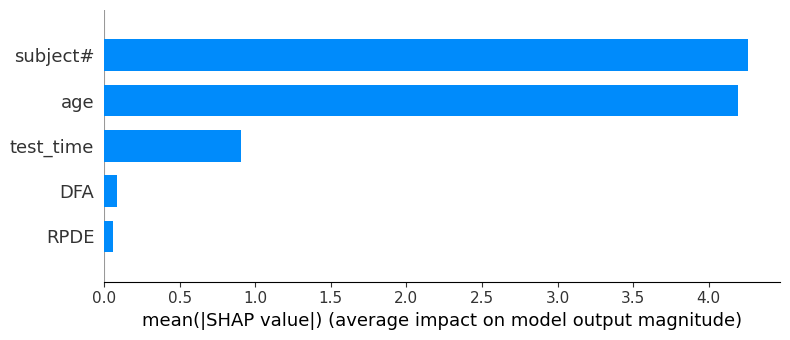

In [7]:
plot_factory = ShapPlotFeatures(shap_feature_selector,type_of_plot='bar_plot')
plot_factory.bar_plot()


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


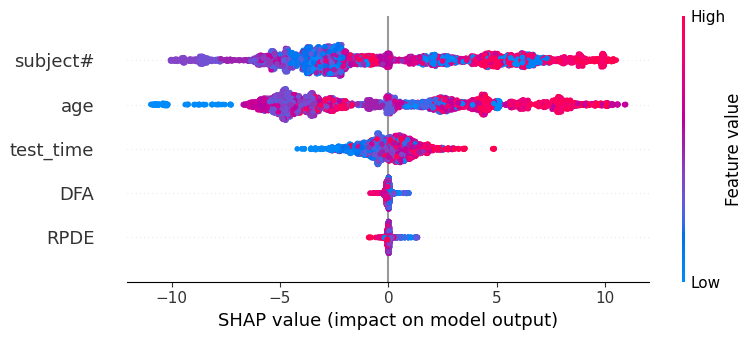

In [8]:
plot_factory.summary_plot()

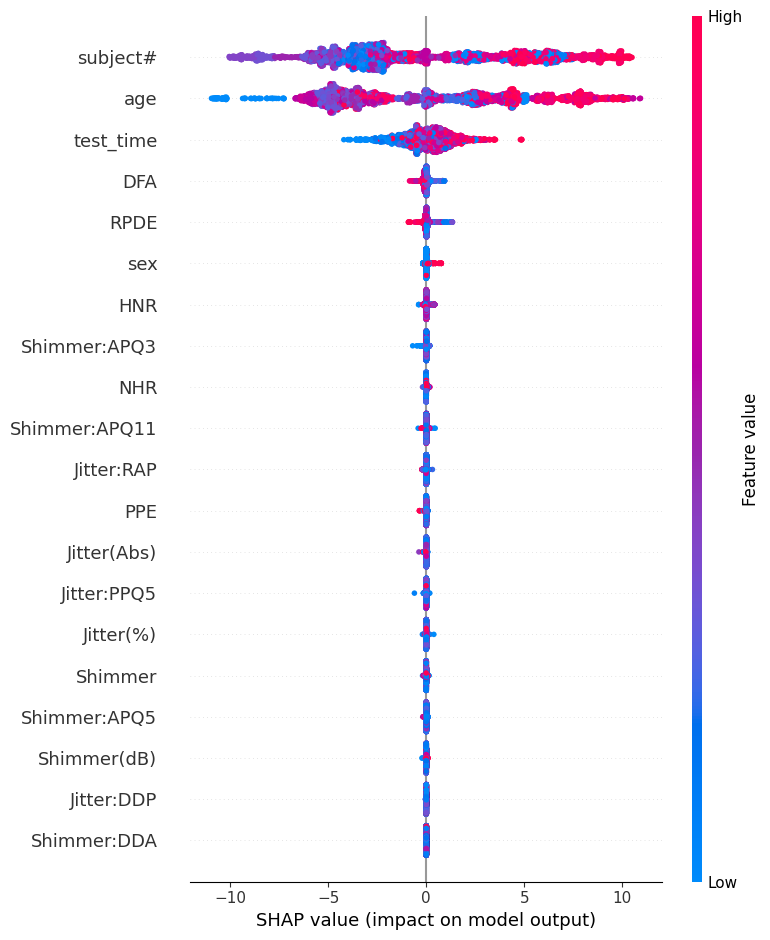

In [9]:
plot_factory.summary_plot_full()